In [1]:
!pip uninstall torchvision -y
!pip install torchvision==0.8.1
!pip install torch==1.6
# !pip install torch==1.6
# !pip install torchvision==0.8.1

Uninstalling torchvision-0.9.1+cu101:
  Successfully uninstalled torchvision-0.9.1+cu101
     |████████████████████████████████| 12.7MB 244kB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.0 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
     |████████████████████████████████| 748.8MB 22kB/s 
ERROR: torchvision 0.8.1 has requirement torch==1.7.0, but you'll have torch 1.6.0 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.6.0 which is incompatible.
  Found existing installation: torch 1.7.0
    Uninstalling torch-1.7.0:
      Successfully uninstalled torch-1.7.0


In [2]:
import numpy as np
import matplotlib.pylab as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import time
from torch.autograd import Variable, Function
from torchsummary import summary
from torchvision import transforms, datasets
from torchvision.datasets import VisionDataset, ImageFolder
import matplotlib.pyplot as plt
import itertools
import math
from torch.nn.modules.utils import _pair

In [3]:
BATCH_SIZE = 100
NUM_CLASSES = 10

In [4]:
transform = transforms.Compose([
  # transforms.RandomResizedCrop(224),
  transforms.ToTensor()
])

In [5]:
train_data = torchvision.datasets.Caltech101(
    root = './',
    transform = transform,
    download=True
)

Files already downloaded and verified


In [6]:
caltech_data = datasets.ImageFolder("./caltech101/101_ObjectCategories/", transform=transform)
caltech_data_size = len(caltech_data)
train_data_size = int(0.7 * caltech_data_size)
val_data_size = (caltech_data_size - train_data_size)//2
test_data_size = caltech_data_size - train_data_size - val_data_size

In [7]:
train_data, val_test_data = torch.utils.data.random_split(caltech_data, [train_data_size, caltech_data_size-train_data_size])
val_data, test_data = torch.utils.data.random_split(val_test_data, [val_data_size, test_data_size])

In [8]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [9]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2, drop_last=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
def validate(model, args):
    criterion = nn.CrossEntropyLoss()
    total = 0
    for i, (xs, ys) in enumerate(testloader):
        images, labels = get_torch_vars(xs, ys, args.gpu)
        outputs = model(images)
        predict = torch.argmax(outputs, dim=1)
        total += torch.sum(labels == predict)
    return total.item() / (len(testloader) * BATCH_SIZE)

In [11]:
def get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.

    Args:
      xs (float numpy tenosor): greyscale input
      ys (int numpy tenosor): categorical labels
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)

In [12]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def train(model, args):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
    print("Beginning training ...")
    if args.gpu:
        model.cuda()
    start = time.time()
    # print(1)
    train_losses = []
    valid_accs = []
    for epoch in range(args.epochs):
        # Train the Model
        model.train()  # Change model to 'train' mode
        losses = []
        # print(1)
        for i, (xs, ys) in enumerate(trainloader):
            images, labels = get_torch_vars(xs, ys, args.gpu)
            # Forward + Backward + Optimize
            # print(labels)
            # print(images.size())
            optimizer.zero_grad()
            outputs = model(images)

            # print(outputs.view(BATCH_SIZE, NUM_CLASSES))

            loss = criterion(outputs.view(BATCH_SIZE, NUM_CLASSES), labels)
            print("i:", i, "loss:", loss)
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())
        avg_loss = np.mean(losses)
        train_losses.append(avg_loss)
        time_elapsed = time.time() - start
        print(
            "Epoch [%d/%d], Loss: %.4f, Time (s): %d"
            % (epoch + 1, args.epochs, avg_loss, time_elapsed)
        )
        model.eval()
        val_acc = validate(model, args)
        valid_accs.append(val_acc)
        print(
            "Epoch [%d/%d], Validation Accuracy: %.4f"
            % (epoch + 1, args.epochs, val_acc)
        )
    return model, train_losses, valid_accs

In [79]:
a = torch.Tensor(np.ones((32, 2,2,2)))
c = torch.Tensor(np.ones((32, 2,1,2)))
b = torch.cat((a, c),dim=2)
print(b.shape)

torch.Size([32, 2, 3, 2])


In [92]:
class SpectralPooling2d(nn.Module):
    def __init__(self, kernel_size):
        super(SpectralPooling2d, self).__init__()

        self.kernel_size = 2

    def crop_spectrum(self, z, H, W):
        '''
            z: [bs, c, M, N, 2]
            Return: [bs, c, H, H, 2]
        '''
        M, N = z.size(-3), z.size(-2)
        topleft = z[..., :M//2-H//2+1, :N//2-W//2+1, :]
        topright = z[..., :M//2-H//2+1, N//2+W//2:, :]
        bottomleft = z[..., M//2+H//2:, :N//2-W//2+1, :]
        bottomright = z[...,M//2+H//2:, N//2+W//2:, :]
        top = torch.cat((topleft, topright), dim=3)
        bottom = torch.cat((bottomleft, bottomright), dim=3)

        return torch.cat((top, bottom),dim=2)


        #return z[..., M//2-H//2:M//2+H//2, N//2-W//2:N//2+W//2, :]

    def pad_spectrum(self, z, M, N):
        '''
            z: [bs, c, H, W, 2]
            Return: [bs, c, M, N, 2]
        '''
        H, W = z.size(-3), z.size(-2)
        z_real, z_imag = z[..., 0], z[..., 1]
        pad = torch.nn.ZeroPad2d((N-W)//2, (N-W)//2, (M-H)//2, (M-H)//2)
        return torch.stack([pad(z_real), pad(z_imag)], dim = -1)

    def treat_corner_cases(self, freq_map):
        '''
            freq_map: [bs, c, M, N, 2]
        '''
        S = [(0, 0)]
        M, N = freq_map.size(-3), freq_map.size(-2)

        if M % 2 == 1:
            S.append((M // 2, 0))
        if N % 2 == 1:
            S.append((0, N // 2))
        if M % 2 == 1 and N % 2 == 1:
            S.append((M // 2, N // 2))

        for h, w in S:
            freq_map[..., h, w, 1].zero_()

        return freq_map, S

    def remove_redundancy(self, y):
        '''
            y: input gradient map [bs, c, M, N, 2]
        '''
        z, S = self.treat_corner_cases(y)
        I = []
        M, N = y.size(-3), y.size(-2)

        for m in range(M):
            for n in range(N // 2 + 1):
                if (m, n) not in S:
                    if (m, n) not in I:
                        z[..., m, n, :].mul_(2)
                        I.append((m, n))
                        I.append(((M - m) % M, (N - n) % N))
                    else:
                        z[..., m, n, :].zero_()
        
        return z

    def recover_map(self, y):
        z, S = self.treat_corner_cases(y)
        I = []
        M, N = y.size(-3), y.size(-2)

        for m in range(M):
            for n in range(N // 2 + 1):
                if (m, n) not in S:
                    if (m, n) not in I:
                        z[..., m, n, :].mul_(0.5)
                        z[..., (M-m)%M, (N-n)%N] = z[..., m, n, :]
                        I.append((m, n))
                        I.append(((M - m) % M, (N - n) % N))
                    else:
                        z[..., m, n, :].zero_()

        return z

    def forward(self, x):
        M, N = x.size(-2), x.size(-1)
        H, W = M // self.kernel_size, N // self.kernel_size

        x_fft = torch.rfft(x, 2, onesided = False)
        crop_x_fft = self.crop_spectrum(x_fft, H, W)
        crop_x_fft, _ = self.treat_corner_cases(crop_x_fft)
        pool_x = torch.irfft(crop_x_fft, 2, onesided = False)
        return pool_x

    def backward(self, gRgx):
        H, W = gRgx.size(-2), gRgx.size(-1)
        M, N = H * self.kernel_size, W * self.kernel_size

        z = torch.rfft(gRgx, 2, onesided = False)
        z = self.remove_redundancy(z)
        z = self.pad_spectrum(z, M, N)
        z = self.recover_map(z)
        gRx = torch.irfft(z, 2, onesided = False)

        return gRx

In [93]:
class CNNMNIST(nn.Module):
    def __init__(self):
        super(CNNMNIST, self).__init__()

        self.net1 = nn.Sequential(
            nn.Conv2d(3, 32, 3),
            nn.ReLU(True),
            Denoise(0.05),
            nn.Conv2d(32, 64, 3),
            nn.MaxPool2d(2))
        self.net2 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(14*14*64, 128),
            nn.ReLU(True),
            nn.Linear(128, 10),
            nn.LogSoftmax(1)
        )
        self.name = 'VanillaCNN'

    def forward(self, x):

        x = self.net1(x)
        # print(x.size())
        return self.net2(x)


class FCNNMNIST(nn.Module):
    def __init__(self):
        super(FCNNMNIST, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3),
            SpectralPooling2d(0.5),
            #GaussianPooling2d(64, 2, 2),
            nn.Flatten(),
            nn.Linear(14*14*64, 128),
            nn.ReLU(True),
            nn.Linear(128, 10),
            nn.LogSoftmax(1)
        )
        self.name = 'FourierCNN'

    def forward(self, x):
        return self.net(x)


def weight_init(net):
    for module in net.modules():
        if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
            torch.nn.init.uniform_(module.weight, -0.1, 0.1)
            if module.bias is not None:
                torch.nn.init.constant_(module.bias, 0)

In [94]:
# args = AttrDict()
# torch.cuda.empty_cache()
# model = FCNNMNIST()
# model.cuda()
# args_dict = {
#     "gpu": True,
#     "epochs": 20,
#     "learning_rate": 1e-3
# }
# weight_init(model)
# args.update(args_dict)
# final_model, train_losses, valid_accs = train(model, args)

In [102]:
spectral_model = torch.hub.load('pytorch/vision:v0.8.1', 'vgg16', pretrained=False)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.8.1


In [103]:
spectral_model.features[4] =  SpectralPooling2d(0.5).cuda()
spectral_model.features[9] = SpectralPooling2d(0.5).cuda()
spectral_model.features[16] = SpectralPooling2d(0.5).cuda()
spectral_model.features[23] = SpectralPooling2d(0.5).cuda()
# spectral_model.features[30] = SpectralPooling2d(0.5).cuda()
# spectral_model.avgpool = nn.AdaptiveAvgPool2d(output_size=(7,7)).cuda()
# spectral_model.classifier[0] = nn.Linear(18432, 4096).cuda()
spectral_model.classifier[6] = nn.Linear(4096, NUM_CLASSES).cuda()

In [104]:
args = AttrDict()
torch.cuda.empty_cache()
spectral_model.cuda()
args_dict = {
    "gpu": True,
    "epochs": 10,
    "learning_rate": 1e-4
}
args.update(args_dict)
final_model_spectral, train_losses_spectral, valid_accs_spectral = train(spectral_model, args)

Streaming output truncated to the last 5000 lines.
i: 20 loss: tensor(2.2810, device='cuda:0', grad_fn=<NllLossBackward>)
i: 21 loss: tensor(2.2877, device='cuda:0', grad_fn=<NllLossBackward>)
i: 22 loss: tensor(2.2559, device='cuda:0', grad_fn=<NllLossBackward>)
i: 23 loss: tensor(2.2714, device='cuda:0', grad_fn=<NllLossBackward>)
i: 24 loss: tensor(2.2768, device='cuda:0', grad_fn=<NllLossBackward>)
i: 25 loss: tensor(2.2530, device='cuda:0', grad_fn=<NllLossBackward>)
i: 26 loss: tensor(2.2525, device='cuda:0', grad_fn=<NllLossBackward>)
i: 27 loss: tensor(2.2672, device='cuda:0', grad_fn=<NllLossBackward>)
i: 28 loss: tensor(2.1856, device='cuda:0', grad_fn=<NllLossBackward>)
i: 29 loss: tensor(2.2261, device='cuda:0', grad_fn=<NllLossBackward>)
i: 30 loss: tensor(2.2163, device='cuda:0', grad_fn=<NllLossBackward>)
i: 31 loss: tensor(2.2274, device='cuda:0', grad_fn=<NllLossBackward>)
i: 32 loss: tensor(2.1801, device='cuda:0', grad_fn=<NllLossBackward>)
i: 33 loss: tensor(2.2225,

In [105]:
vgg_model = torch.hub.load('pytorch/vision:v0.8.1', 'vgg16', pretrained=False)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.8.1


In [106]:
# spectral_model.features[4] =  SpectralPooling2d(0.5).cuda()
# spectral_model.features[9] = SpectralPooling2d(0.5).cuda()
# spectral_model.features[16] = SpectralPooling2d(0.5).cuda()
# spectral_model.features[23] = SpectralPooling2d(0.5).cuda()
# spectral_model.features[30] = SpectralPooling2d(0.5).cuda()
# spectral_model.avgpool = nn.AdaptiveAvgPool2d(output_size=(7,7)).cuda()
# spectral_model.classifier[0] = nn.Linear(18432, 4096).cuda()
vgg_model.classifier[6] = nn.Linear(4096, NUM_CLASSES).cuda()

In [108]:
args = AttrDict()
torch.cuda.empty_cache()
vgg_model.cuda()
args_dict = {
    "gpu": True,
    "epochs": 10,
    "learning_rate": 1e-4
}
args.update(args_dict)
final_model_max, train_losses_max, valid_accs_max = train(vgg_model, args)

Streaming output truncated to the last 5000 lines.
i: 20 loss: tensor(2.1399, device='cuda:0', grad_fn=<NllLossBackward>)
i: 21 loss: tensor(2.3838, device='cuda:0', grad_fn=<NllLossBackward>)
i: 22 loss: tensor(2.2689, device='cuda:0', grad_fn=<NllLossBackward>)
i: 23 loss: tensor(2.1776, device='cuda:0', grad_fn=<NllLossBackward>)
i: 24 loss: tensor(2.2197, device='cuda:0', grad_fn=<NllLossBackward>)
i: 25 loss: tensor(2.2666, device='cuda:0', grad_fn=<NllLossBackward>)
i: 26 loss: tensor(2.2592, device='cuda:0', grad_fn=<NllLossBackward>)
i: 27 loss: tensor(2.2466, device='cuda:0', grad_fn=<NllLossBackward>)
i: 28 loss: tensor(2.2407, device='cuda:0', grad_fn=<NllLossBackward>)
i: 29 loss: tensor(2.2198, device='cuda:0', grad_fn=<NllLossBackward>)
i: 30 loss: tensor(2.1484, device='cuda:0', grad_fn=<NllLossBackward>)
i: 31 loss: tensor(2.2121, device='cuda:0', grad_fn=<NllLossBackward>)
i: 32 loss: tensor(2.2373, device='cuda:0', grad_fn=<NllLossBackward>)
i: 33 loss: tensor(2.1713,

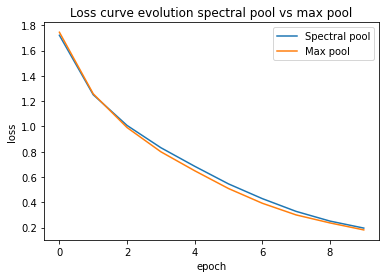

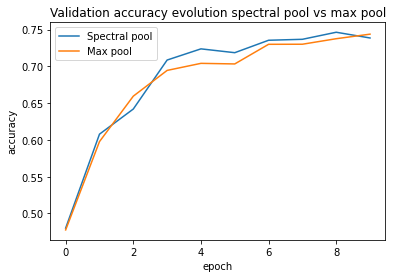

In [109]:
epochs_arr = np.arange(0, args_dict['epochs'])

plt.plot(epochs_arr, train_losses_spectral, label='Spectral pool')
plt.plot(epochs_arr, train_losses_max, label='Max pool')
plt.title('Loss curve evolution spectral pool vs max pool')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(epochs_arr, valid_accs_spectral, label='Spectral pool')
plt.plot(epochs_arr, valid_accs_max, label='Max pool')
plt.title('Validation accuracy evolution spectral pool vs max pool')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [110]:
valid_accs_spectral

[0.4801, 0.6078, 0.642, 0.7086, 0.7238, 0.7186, 0.7355, 0.7368, 0.7464, 0.7386]